# Assignment:2 Deep learning for timeseries

## Different kinds of timeseries tasks

## A Temperature forecasting Example- Downloading and uncompressing the data

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-09 00:20:10--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.245.206, 52.217.102.22, 52.216.76.246, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.245.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

100%[======================================>] 13,565,642  23.2MB/s   in 0.6s   

2024-04-09 00:20:11 (23.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Inspecting the Data of the Jena weather dataset

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values), as well as the following header:

["Date Time",

"p (mbar)",

"T (degC)",

"Tpot (K)",

"Tdew (degC)", "rh (%)",

"VPmax (mbar)",

"VPact (mbar)",

"VPdef (mbar)",

"sh (g/kg)",

"H2OC (mmol/mol)",

"rho (g/m**3)",

"wv (m/s)",

"max. wv (m/s)",

"wd (deg)"]

## Parsing the data

Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.



In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
 values = [float(x) for x in line.split(",")[1:]]
 temperature[i] = values[1]
 raw_data[i, :] = values[:]

## Plotting the temperature timeseries

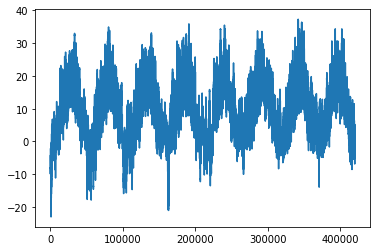

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

The above graph shows the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

## Plotting the first 10 days of the temperature timeseries

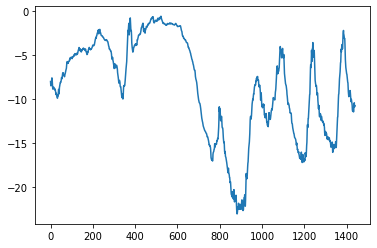

In [5]:
plt.plot(range(1440), temperature[:1440])

The above plot shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

## Computing the number of samples we'll use for each data split

We’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Preparing the data

## Normalizing the data

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


## Instantiating datasets for training, validation, and testing

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

## Inspecting the output of one of our datasets

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


# A common-sense, non-machine-learning baseline

## Computing the common-sense baseline MAE

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.

# Let’s try a basic machine learning model

## Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=6,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/6
819/819 [==============================] - 11s 12ms/step - loss: 13.0706 - mae: 2.7886 - val_loss: 15.2664 - val_mae: 3.1126
Epoch 2/6
819/819 [==============================] - 10s 12ms/step - loss: 9.1985 - mae: 2.3910 - val_loss: 11.5397 - val_mae: 2.6928
Epoch 3/6
819/819 [==============================] - 10s 12ms/step - loss: 8.4070 - mae: 2.2855 - val_loss: 13.0261 - val_mae: 2.8581
Epoch 4/6
819/819 [==============================] - 10s 12ms/step - loss: 7.9105 - mae: 2.2178 - val_loss: 11.6024 - val_mae: 2.6983
Epoch 5/6
819/819 [==============================] - 9s 11ms/step - loss: 7.5653 - mae: 2.1671 - val_loss: 11.4743 - val_mae: 2.6710
Epoch 6/6
405/405 [==============================] - 3s 6ms/step - loss: 12.4708 - mae: 2.7912
Test MAE: 2.79


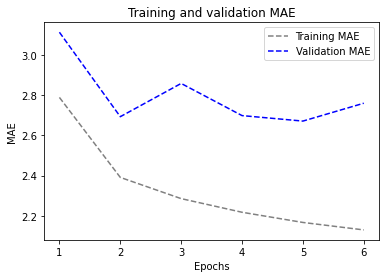

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=6,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/6
819/819 [==============================] - 27s 32ms/step - loss: 24.3566 - mae: 3.8486 - val_loss: 19.6684 - val_mae: 3.4674
Epoch 2/6
819/819 [==============================] - 25s 30ms/step - loss: 19.2382 - mae: 3.4209 - val_loss: 17.6125 - val_mae: 3.2886
Epoch 3/6
819/819 [==============================] - 25s 31ms/step - loss: 17.7032 - mae: 3.2755 - val_loss: 16.5686 - val_mae: 3.1996
Epoch 4/6
819/819 [==============================] - 25s 30ms/step - loss: 16.6936 - mae: 3.1783 - val_loss: 16.8799 - val_mae: 3.2735
Epoch 5/6
819/819 [==============================] - 25s 30ms/step - loss: 15.9071 - mae: 3.1042 - val_loss: 16.9451 - val_mae: 3.2452
Epoch 6/6
405/405 [==============================] - 6s 13ms/step - loss: 18.5332 - mae: 3.3776
Test MAE: 3.38


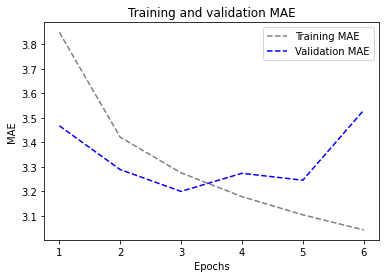

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# A first recurrent baseline

### **A Simple LSTM-based model**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 44s 52ms/step - loss: 43.5079 - mae: 4.8080 - val_loss: 13.2252 - val_mae: 2.7573
Epoch 2/5
819/819 [==============================] - 41s 50ms/step - loss: 11.2894 - mae: 2.6120 - val_loss: 10.0303 - val_mae: 2.4670
Epoch 3/5
819/819 [==============================] - 41s 50ms/step - loss: 10.0625 - mae: 2.4782 - val_loss: 10.0924 - val_mae: 2.4643
Epoch 4/5
819/819 [==============================] - 39s 48ms/step - loss: 9.6097 - mae: 2.4191 - val_loss: 10.1117 - val_mae: 2.4640
Epoch 5/5
405/405 [==============================] - 6s 14ms/step - loss: 10.7985 - mae: 2.5619
Test MAE: 2.56


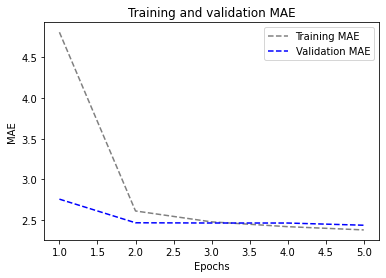

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

### **A Simple RNN-An RNN layer that can process sequences of any length**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 17s 20ms/step - loss: 139.2875 - mae: 9.7205 - val_loss: 144.1719 - val_mae: 9.9208
Epoch 2/5
819/819 [==============================] - 17s 21ms/step - loss: 136.4977 - mae: 9.5704 - val_loss: 143.9748 - val_mae: 9.9002
Epoch 3/5
819/819 [==============================] - 16s 20ms/step - loss: 136.3154 - mae: 9.5517 - val_loss: 143.6643 - val_mae: 9.8651
Epoch 4/5
819/819 [==============================] - 17s 20ms/step - loss: 136.2293 - mae: 9.5421 - val_loss: 143.6054 - val_mae: 9.8572
Epoch 5/5
405/405 [==============================] - 4s 10ms/step - loss: 151.3978 - mae: 9.9300
Test MAE: 9.93


**An RNN layer that returns only its last output step**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


### **Stacking RNN**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/5
819/819 [==============================] - 48s 57ms/step - loss: 137.0668 - mae: 9.5729 - val_loss: 143.4172 - val_mae: 9.8372
Epoch 2/5
819/819 [==============================] - 48s 59ms/step - loss: 135.9356 - mae: 9.5102 - val_loss: 143.3995 - val_mae: 9.8345
Epoch 3/5
819/819 [==============================] - 51s 62ms/step - loss: 135.9023 - mae: 9.5059 - val_loss: 143.4010 - val_mae: 9.8346
Epoch 4/5
819/819 [==============================] - 52s 63ms/step - loss: 135.8800 - mae: 9.5022 - val_loss: 143.4081 - val_mae: 9.8383
Epoch 5/5
405/405 [==============================] - 7s 17ms/step - loss: 151.1172 - mae: 9.9025
Test MAE: 9.90


### **A Simple GRU based model**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 40s 47ms/step - loss: 36.6066 - mae: 4.3483 - val_loss: 11.6421 - val_mae: 2.6040
Epoch 2/5
819/819 [==============================] - 37s 46ms/step - loss: 10.5993 - mae: 2.5410 - val_loss: 9.7816 - val_mae: 2.4302
Epoch 3/5
819/819 [==============================] - 36s 44ms/step - loss: 9.8407 - mae: 2.4550 - val_loss: 9.4237 - val_mae: 2.3745
Epoch 4/5
819/819 [==============================] - 36s 44ms/step - loss: 9.3421 - mae: 2.3904 - val_loss: 9.3914 - val_mae: 2.3648
Epoch 5/5
405/405 [==============================] - 5s 12ms/step - loss: 10.0974 - mae: 2.5106
Test MAE: 2.51


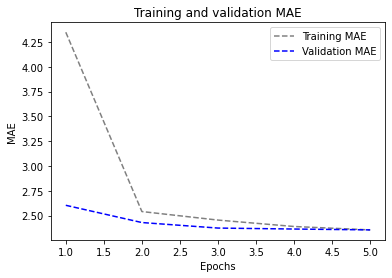

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## Advanced use of recurrent neural networks

### **LSTM with dropout-Training and evaluating a dropout-regularized LSTM**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 71s 85ms/step - loss: 43.1632 - mae: 4.8929 - val_loss: 12.5449 - val_mae: 2.6944
Epoch 2/5
819/819 [==============================] - 72s 87ms/step - loss: 19.8413 - mae: 3.4183 - val_loss: 9.6953 - val_mae: 2.4316
Epoch 3/5
819/819 [==============================] - 70s 86ms/step - loss: 18.4511 - mae: 3.2992 - val_loss: 9.3354 - val_mae: 2.3953
Epoch 4/5
819/819 [==============================] - 71s 86ms/step - loss: 17.5304 - mae: 3.2212 - val_loss: 9.5845 - val_mae: 2.4330
Epoch 5/5
405/405 [==============================] - 5s 12ms/step - loss: 10.7198 - mae: 2.5645
Test MAE: 2.56


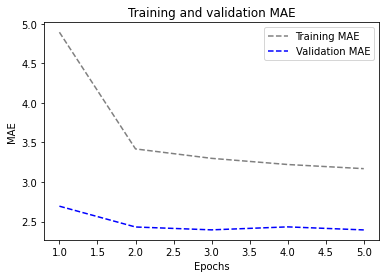

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### Stacking recurrent layers

### **Training and evaluating a dropout-regularized, stacked GRU model**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 131s 155ms/step - loss: 24.6346 - mae: 3.6663 - val_loss: 9.7526 - val_mae: 2.4264
Epoch 2/5
819/819 [==============================] - 126s 154ms/step - loss: 13.9360 - mae: 2.8949 - val_loss: 8.8724 - val_mae: 2.3060
Epoch 3/5
819/819 [==============================] - 125s 153ms/step - loss: 13.2612 - mae: 2.8236 - val_loss: 9.2640 - val_mae: 2.3649
Epoch 4/5
819/819 [==============================] - 126s 154ms/step - loss: 12.7190 - mae: 2.7630 - val_loss: 9.3212 - val_mae: 2.3750
Epoch 5/5
405/405 [==============================] - 12s 28ms/step - loss: 9.9652 - mae: 2.4606
Test MAE: 2.46


## **Q1. Adjusting the number of units in each recurrent layer in the stacked setup and**
## **Q2. Using layer_lstm() instead of layer_gru().**

### **LSTM regularized and stacked with 8 units**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked8.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked8.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 57s 67ms/step - loss: 78.6454 - mae: 6.8499 - val_loss: 39.6179 - val_mae: 4.7317
Epoch 2/5
819/819 [==============================] - 59s 72ms/step - loss: 32.7582 - mae: 4.2663 - val_loss: 14.8815 - val_mae: 2.8908
Epoch 3/5
819/819 [==============================] - 63s 77ms/step - loss: 24.0208 - mae: 3.7015 - val_loss: 11.2417 - val_mae: 2.5794
Epoch 4/5
819/819 [==============================] - 58s 71ms/step - loss: 22.1100 - mae: 3.5597 - val_loss: 10.8466 - val_mae: 2.5419
Epoch 5/5
405/405 [==============================] - 8s 18ms/step - loss: 11.9554 - mae: 2.6696
Test MAE: 2.67


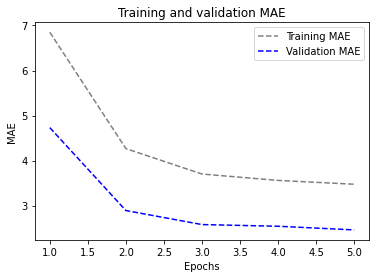

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM regularized and stacked with 16 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked16.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked16.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 71s 84ms/step - loss: 46.9006 - mae: 5.0834 - val_loss: 14.0608 - val_mae: 2.8341
Epoch 2/5
819/819 [==============================] - 70s 85ms/step - loss: 18.3570 - mae: 3.2772 - val_loss: 9.9032 - val_mae: 2.4549
Epoch 3/5
819/819 [==============================] - 67s 81ms/step - loss: 16.6160 - mae: 3.1191 - val_loss: 9.7728 - val_mae: 2.4439
Epoch 4/5
819/819 [==============================] - 71s 86ms/step - loss: 15.5341 - mae: 3.0171 - val_loss: 10.1097 - val_mae: 2.4829
Epoch 5/5
405/405 [==============================] - 11s 25ms/step - loss: 11.1538 - mae: 2.6095
Test MAE: 2.61


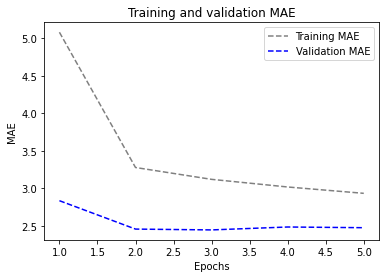

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM regularized and stacked with 32 units**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked32.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked32.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 101s 120ms/step - loss: 27.0678 - mae: 3.8075 - val_loss: 10.1141 - val_mae: 2.4984
Epoch 2/5
819/819 [==============================] - 102s 124ms/step - loss: 12.8951 - mae: 2.7747 - val_loss: 10.6042 - val_mae: 2.5319
Epoch 3/5
819/819 [==============================] - 105s 129ms/step - loss: 11.4502 - mae: 2.6168 - val_loss: 9.5854 - val_mae: 2.4292
Epoch 4/5
819/819 [==============================] - 107s 131ms/step - loss: 10.4813 - mae: 2.4968 - val_loss: 10.7430 - val_mae: 2.5544
Epoch 5/5
405/405 [==============================] - 17s 41ms/step - loss: 10.8330 - mae: 2.5987
Test MAE: 2.60


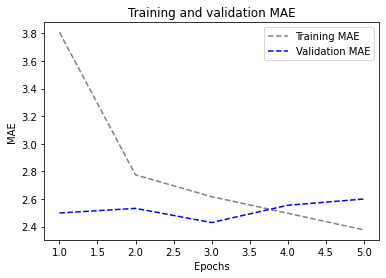

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM regularized and stacked with 64 units**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked64.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked64.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 189s 228ms/step - loss: 15.9366 - mae: 2.9949 - val_loss: 10.3088 - val_mae: 2.5131
Epoch 2/5
819/819 [==============================] - 187s 228ms/step - loss: 8.6639 - mae: 2.2723 - val_loss: 11.7026 - val_mae: 2.6764
Epoch 3/5
819/819 [==============================] - 187s 228ms/step - loss: 6.6745 - mae: 1.9774 - val_loss: 12.0484 - val_mae: 2.7218
Epoch 4/5
819/819 [==============================] - 186s 227ms/step - loss: 5.5981 - mae: 1.8018 - val_loss: 12.1888 - val_mae: 2.7467
Epoch 5/5
405/405 [==============================] - 36s 87ms/step - loss: 11.5013 - mae: 2.6824
Test MAE: 2.68


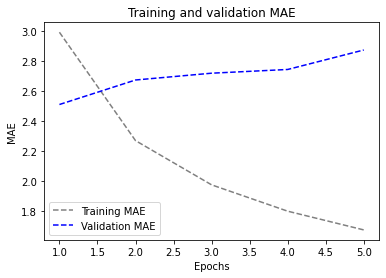

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Using bidirectional RNNs**

### **Training and evaluating a bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 48s 55ms/step - loss: 26.3816 - mae: 3.6814 - val_loss: 10.7920 - val_mae: 2.5518
Epoch 2/5
819/819 [==============================] - 43s 53ms/step - loss: 9.4517 - mae: 2.4007 - val_loss: 10.3747 - val_mae: 2.4913
Epoch 3/5
819/819 [==============================] - 47s 57ms/step - loss: 8.5156 - mae: 2.2785 - val_loss: 10.2107 - val_mae: 2.4629
Epoch 4/5
819/819 [==============================] - 47s 57ms/step - loss: 7.9579 - mae: 2.2055 - val_loss: 10.3143 - val_mae: 2.4894
Epoch 5/5
405/405 [==============================] - 7s 17ms/step - loss: 11.1188 - mae: 2.6088
Test MAE: 2.61


### **3. Using a combination of 1d_convnets and RNN**

### **Combination of 1D Convent and dropout-regularized LSTM**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 43s 50ms/step - loss: 51.0346 - mae: 5.3494 - val_loss: 27.1750 - val_mae: 4.0783
Epoch 2/5
819/819 [==============================] - 39s 48ms/step - loss: 17.5881 - mae: 3.2329 - val_loss: 24.4735 - val_mae: 3.8527
Epoch 3/5
819/819 [==============================] - 40s 48ms/step - loss: 14.2639 - mae: 2.9272 - val_loss: 21.1236 - val_mae: 3.6102
Epoch 4/5
819/819 [==============================] - 39s 48ms/step - loss: 12.5602 - mae: 2.7452 - val_loss: 23.6822 - val_mae: 3.8636
Epoch 5/5
405/405 [==============================] - 7s 16ms/step - loss: 23.3931 - mae: 3.8283
Test MAE: 3.83


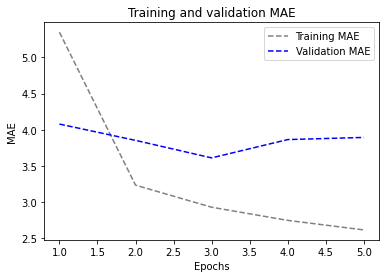

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **MODELS:**

1.Baseline

2.Basic machine learning model

3.1D convolution

4.Simple LSTM

5.Simple RNN

6.Stacked RNN

7.Simple GRU

8.LSTM with dropout

9.Stacked GRU with dropout

10.LSTM dropout

11.LSTM dropout

12.LSTM dropout

13.LSTM dropout

14.Bidirectional RNN

15.1D convolution and LSTM with dropout

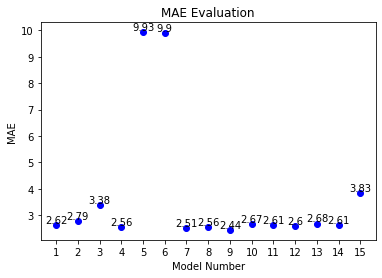

In [21]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15")
Mae = (2.62,2.79,3.38,2.56,9.93,9.90,2.51,2.56,2.44,2.67,2.61,2.60,2.68,2.61,3.83)

# MAE Evaluation
plt.scatter(Models, Mae, color="blue")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

**The RNN model with stacked recurrent layers and layers.GRU() gave the MAE lesser than the baseline MAE i.e 2.62 which means that this model is the efficient one.**

### **Running the best model on the test dataset**

In [28]:
import tensorflow as tf

# Load the saved model with the best validation performance
best_model = tf.keras.models.load_model("jena_stacked_gru_dropout.keras")

# Assuming test_dataset is prepared and contains the test data
# Evaluate the best model on the test dataset
test_mae = best_model.evaluate(test_dataset)[1]

print(f"Test MAE: {test_mae:.2f}")

405/405 [==============================] - 12s 27ms/step - loss: 9.9652 - mae: 2.4606
Test MAE: 2.46
